## Implémentation d’un générateur de lois alpha-stables

### Objectif
Cette première étape consiste à implémenter un générateur permettant de simuler des variables aléatoires suivant une distribution alpha-stable 
𝑆
(
𝛼
,
𝛽
,
𝜎
,
𝜇
)
S(α,β,σ,μ), conformément à la description de l'Appendix B de l’article Sisson (2011). L'algorithme retenu est celui de Chambers, Mallows et Stuck (1976), qui repose sur la transformation de deux lois élémentaires.

### Générateur CMS : implémentation Python


In [10]:
import numpy as np

def sample_alpha_stable(alpha, beta, sigma=1, mu=0, size=1):
    U = np.pi * (np.random.rand(size) - 0.5)  # Uniforme sur (-π/2, π/2)
    W = np.random.exponential(scale=1.0, size=size)  # Exp(1)

    if alpha != 1:
        numerator = np.sin(alpha * U)
        denominator = (np.cos(U))**(1 / alpha)
        inner = np.cos((1 - alpha) * U) / W
        X = numerator / denominator * (inner) ** ((1 - alpha) / alpha)
    else:
        B = (2 / np.pi) * ((np.pi / 2) + beta * U) * np.tan(U) - \
            beta * np.log((np.pi / 2 * W * np.cos(U)) / ((np.pi / 2) + beta * U))
        X = B

    return sigma * X + mu



### Validation empirique : visualisation de quelques lois

Nous testons le générateur pour différentes valeurs de \(\alpha\) et \(\beta\), en représentant les histogrammes des échantillons simulés.



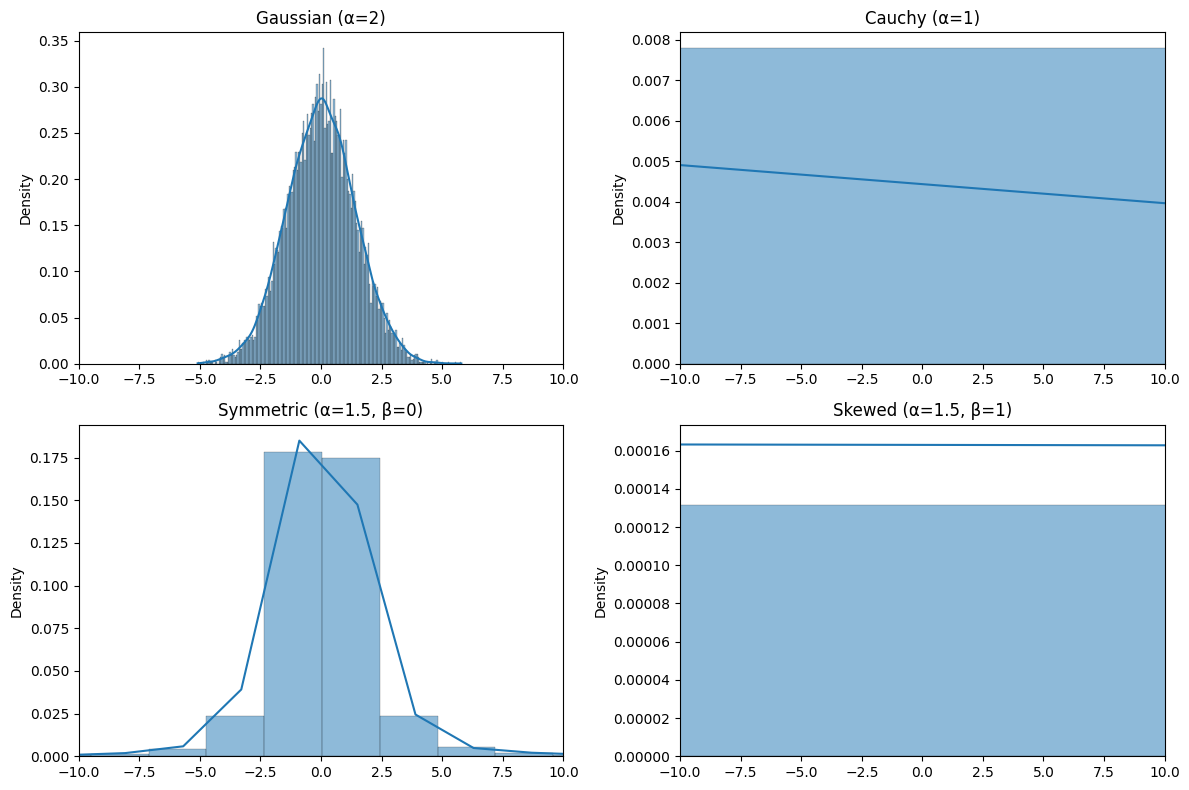

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

params = [
    (2.0, 0, 1, 0, 'Gaussian (α=2)'),
    (1.0, 0, 1, 0, 'Cauchy (α=1)'),
    (1.5, 0, 1, 0, 'Symmetric (α=1.5, β=0)'),
    (1.5, 1, 1, 0, 'Skewed (α=1.5, β=1)'),
]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, (alpha, beta, sigma, mu, title) in enumerate(params):
    data = sample_alpha_stable(alpha, beta, sigma, mu, size=10000)
    sns.histplot(data, kde=True, stat='density', ax=axs[i], bins=200)
    axs[i].set_title(title)
    axs[i].set_xlim(-10, 10)

plt.tight_layout()
plt.show()


L’algorithme de Chambers-Mallows-Stuck fournit une méthode fiable et efficace pour simuler des lois alpha-stables. Il servira de base aux étapes suivantes du projet, en particulier pour les méthodes d’inférence sans vraisemblance de type ABC.
